# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import seaborn as sns
import matplotlib.dates as md


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.metrics import r2_score

In [34]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:,.2f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [35]:
ruta=r'C:\Users\JuanPabloEspinosaCas\OneDrive - Pactia\PACTIA - Operaciones\Python\Curso DataScience\Entregas\Datasets'
data_2019 = pd.read_csv(ruta +'/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv(ruta +'/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv(ruta +'/flujo-vehicular-2017.csv', sep =',')

In [36]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 43.4+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [37]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 73.5+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [38]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 73.3+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [39]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [40]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [41]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [42]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


In [43]:
print(data_2019['hora_fin'].unique())
print(data_2018['hora_fin'].unique())
print(data_2017['hora_fin'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0]


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [44]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [45]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [46]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [47]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


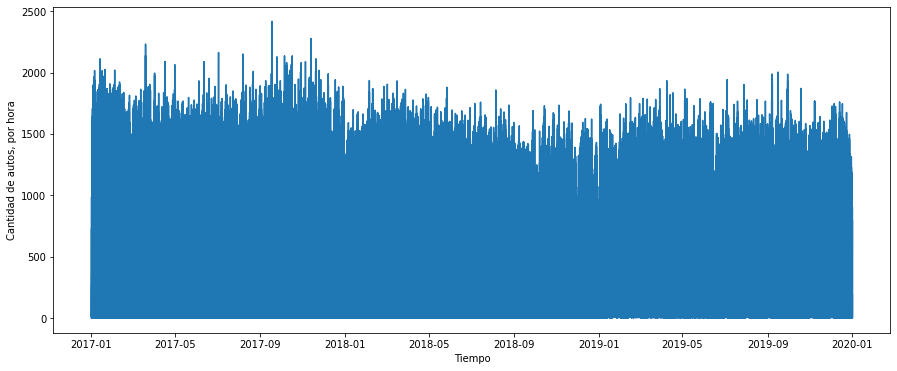

In [48]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [49]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [50]:
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [112]:
dataset.describe()

,cantidad_pasos
count,"238,869.00"
mean,200.38
std,403.25
min,1.00
25%,2.00
50%,11.00
75%,104.00
max,"2,416.00"


In [113]:
dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

Hasta aquí podemos identificar que los datos son adecuados para realizar el analisis preliminar de la información, en la que el resampleo de las fechas sería un punto interesante para leer mejor y entender el dataset. ya las colunmas que no eran significantes fueron eliminadas y condensadas, como por ejemplo la fecha.

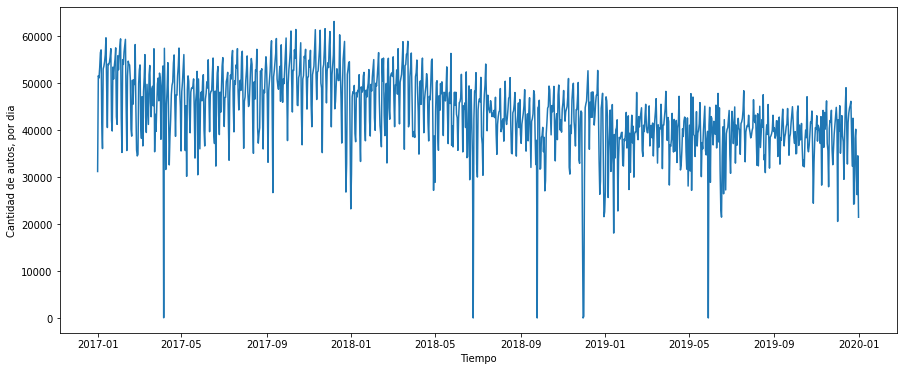

In [51]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [52]:
#vamos a ser un zoom de la información para empezar a entender el comportamiento de los datos
#para esto sugiero hacer una visualización de los tipos de vehiculos para 1 o 2 semanas al azar
t_ini='2018-09-02 00:00:00'
t_fin='2018-09-10 00:00:00'
mask=(dataset.loc[:,'tipo_vehiculo'] == 'Liviano' ) & (dataset.loc[:,'fecha'] >= t_ini ) & (dataset.loc[:,'fecha'] < t_fin)
data_liviano=dataset[mask]
mask2=(dataset.loc[:,'tipo_vehiculo'] == 'Pesado' ) & (dataset.loc[:,'fecha'] >= t_ini ) & (dataset.loc[:,'fecha'] < t_fin)
data_pesado=dataset[mask2]
print(data_liviano.shape)
print(data_pesado.shape)

(803, 5)
(1453, 5)


In [53]:
from matplotlib.dates import DateFormatter

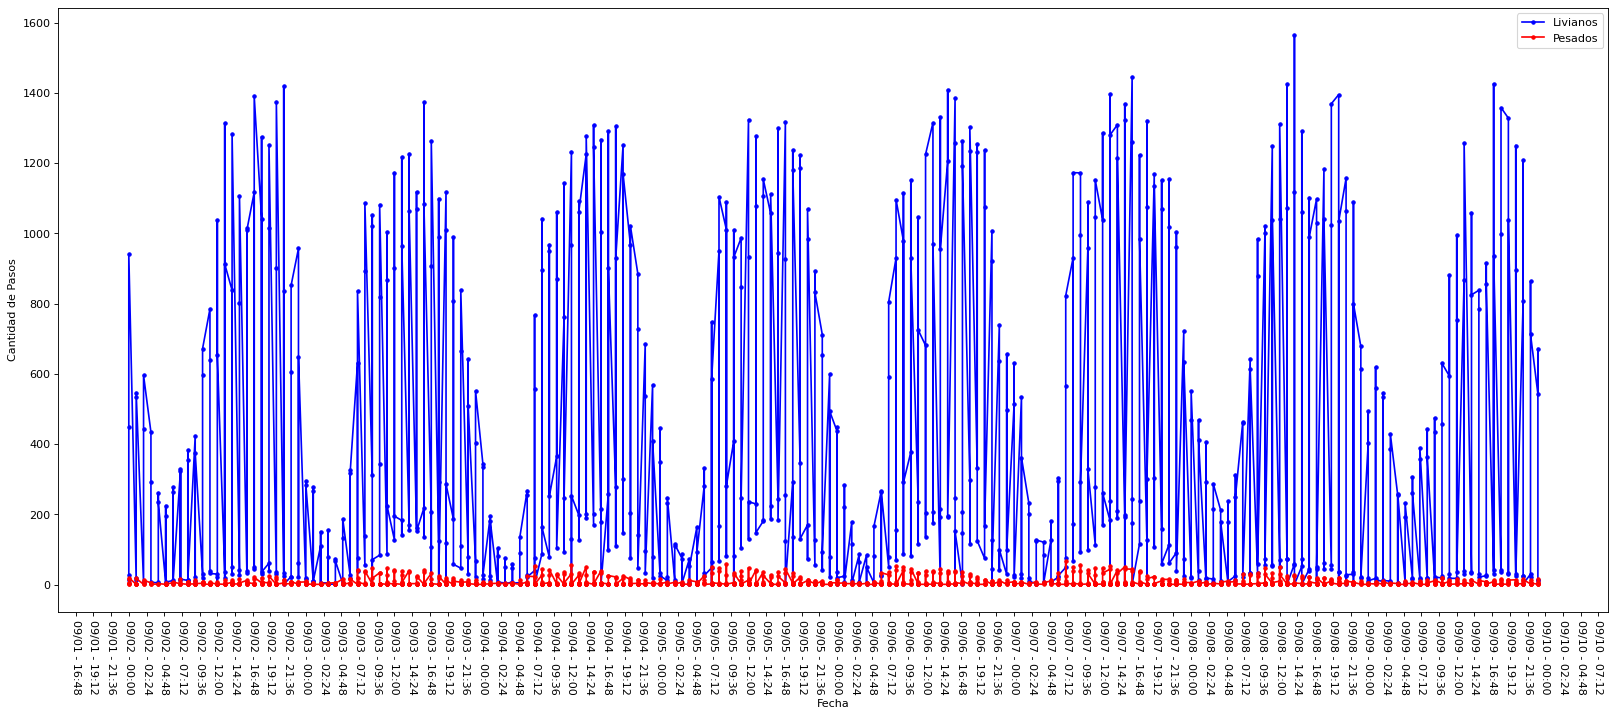

In [54]:
fig, ax = plt.subplots(figsize=(25,10), dpi= 80)
plt.plot(data_liviano.fecha, data_liviano.cantidad_pasos, 'b.-', label = 'Livianos')
plt.plot(data_pesado.fecha, data_pesado.cantidad_pasos, 'r.-', label = 'Pesados')
date_form = DateFormatter("%m/%d - %H:%M")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

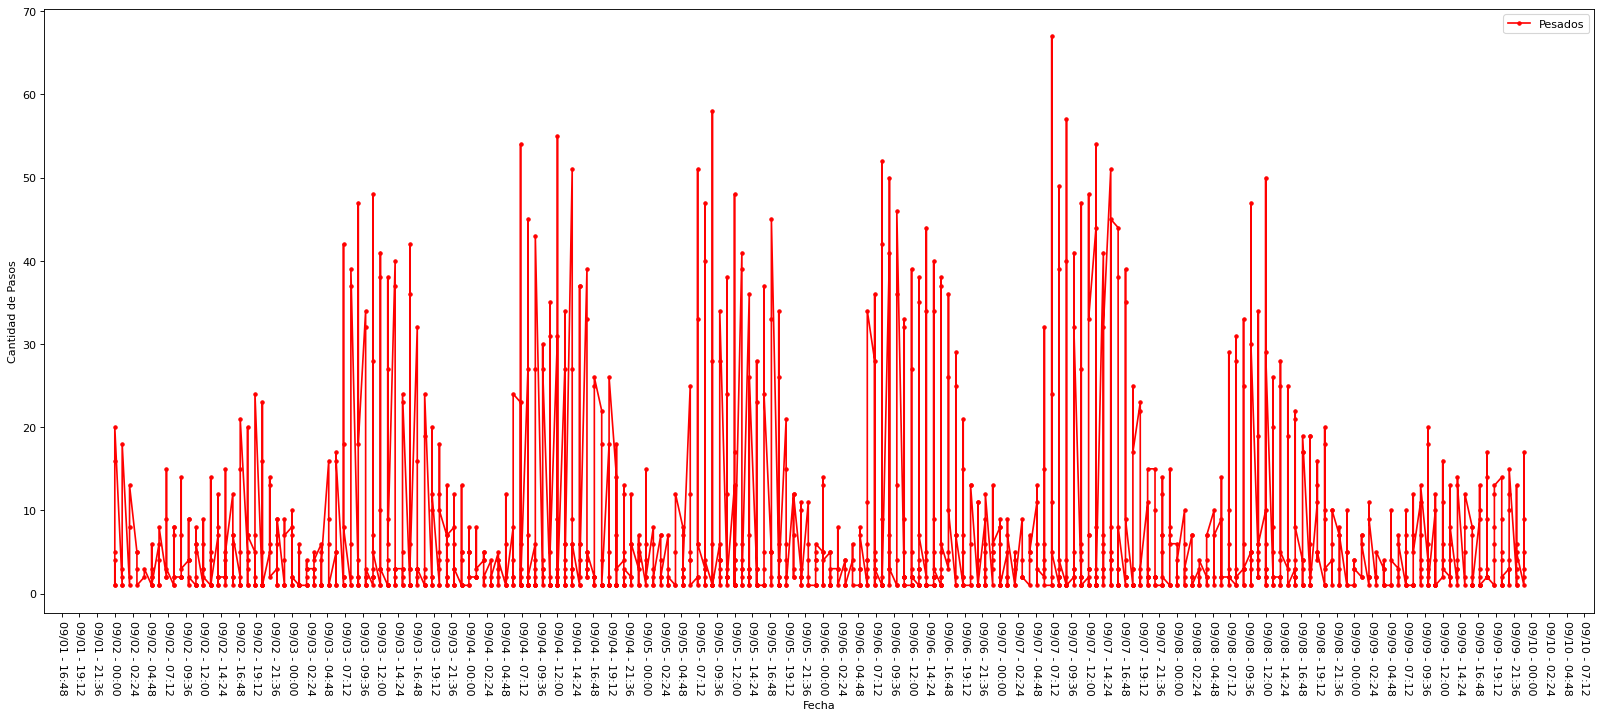

In [55]:
fig, ax = plt.subplots(figsize=(25,10), dpi= 80)
plt.plot(data_pesado.fecha, data_pesado.cantidad_pasos, 'r.-', label = 'Pesados')
date_form = DateFormatter("%m/%d - %H:%M")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

Como podemos observar en las graficas de flujo vehicular en los tipos de vehiculos, se comportan de una manera ciclica, casi con comportamiento normal cada uno. Para los vehiculos livianos presentan una mayor frecuecia de paso entre as 07Hrs y las 21Hrs, manteniendo un sesgo a la derecha es decir una mayor frecuencia de paso entrando las horas de la noche.
por otro lado, los vehiculos pesados aunque el paso es menor su comportamiento es similar.. pero disminuyendo su paso hasta las 19Hrs aprox.

### Componentes de la serie

retomamos el dataset diario para entrar de una manera mas clara y revisar los componentes

In [56]:
diario.head()


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [57]:
# se calcula la tendencia por el a travéz del Rolling Window
ventana = 7 
promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()
promedio_tendencia.describe()

count    1,089.00
mean    43,744.30
std      5,244.92
min     25,761.14
25%     39,664.57
50%     43,702.00
75%     47,878.14
max     54,098.00
Name: cantidad_pasos, dtype: float64

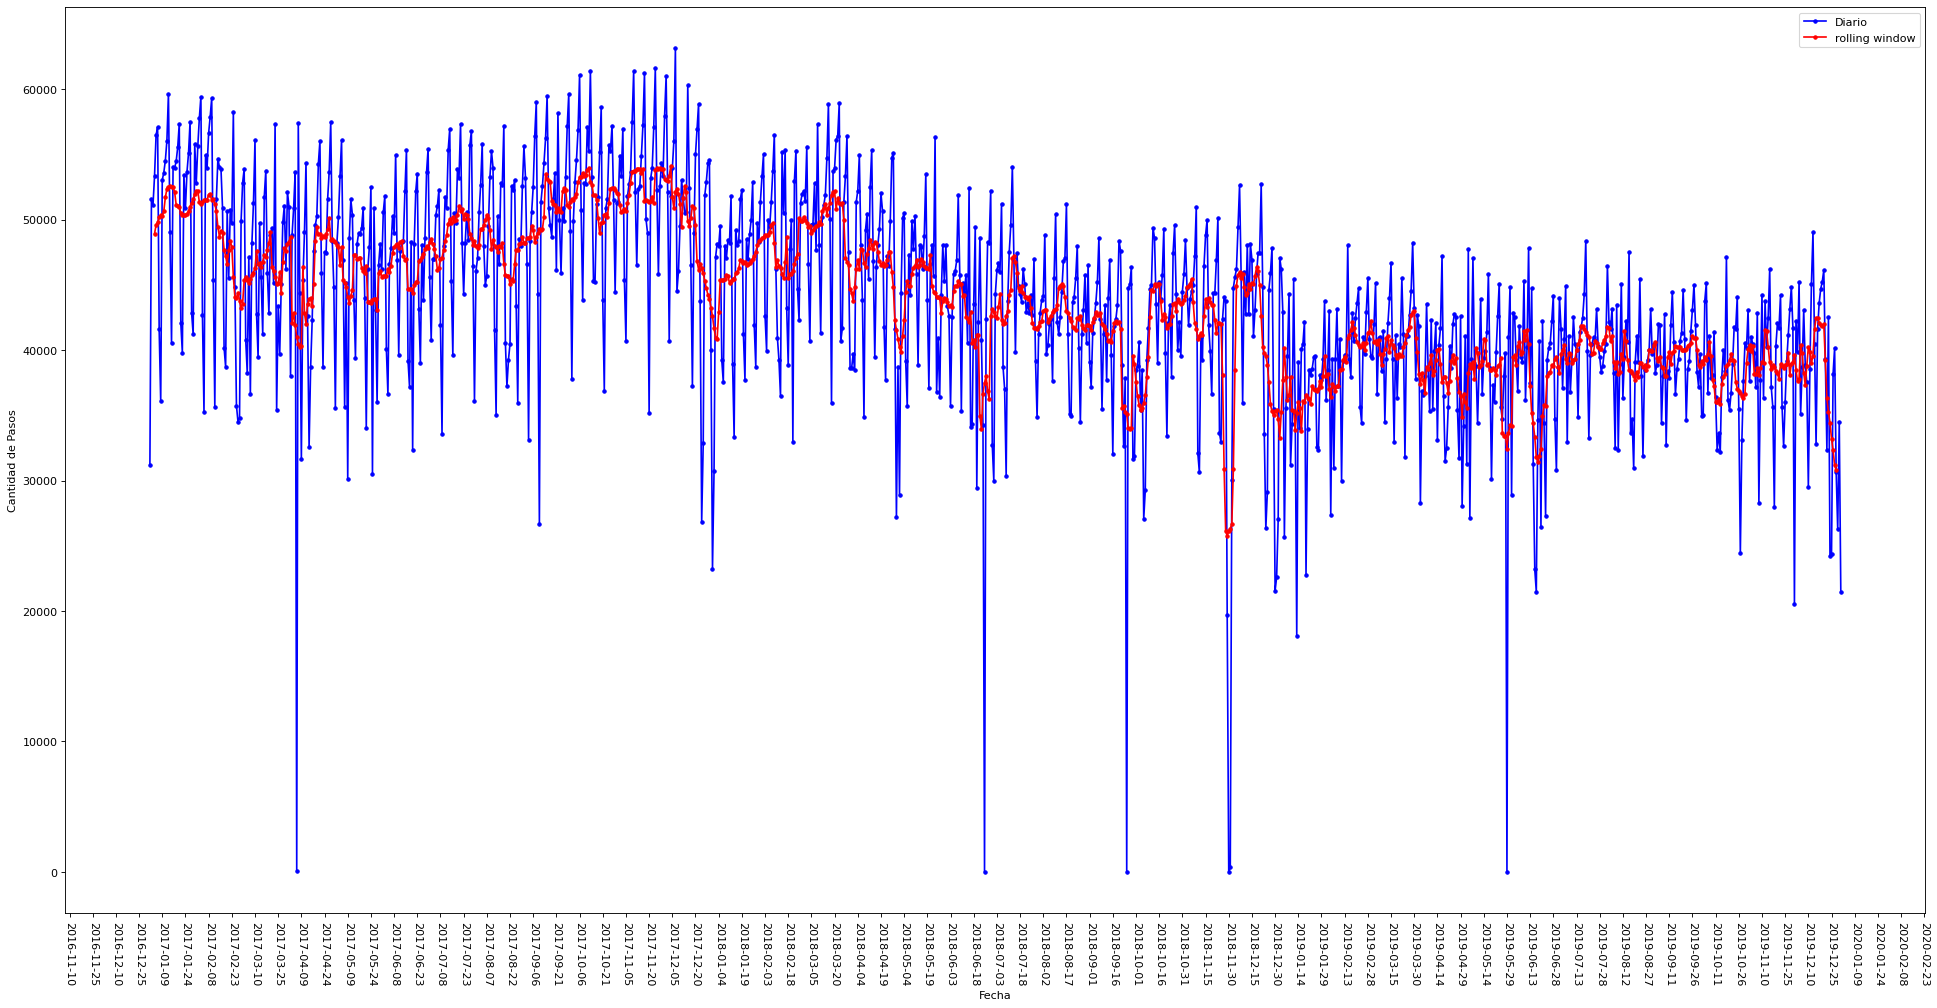

In [58]:
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(diario.index, diario.cantidad_pasos, 'b.-', label = 'Diario')
plt.plot(promedio_tendencia,  'r.-', label = 'rolling window')
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Pasos')

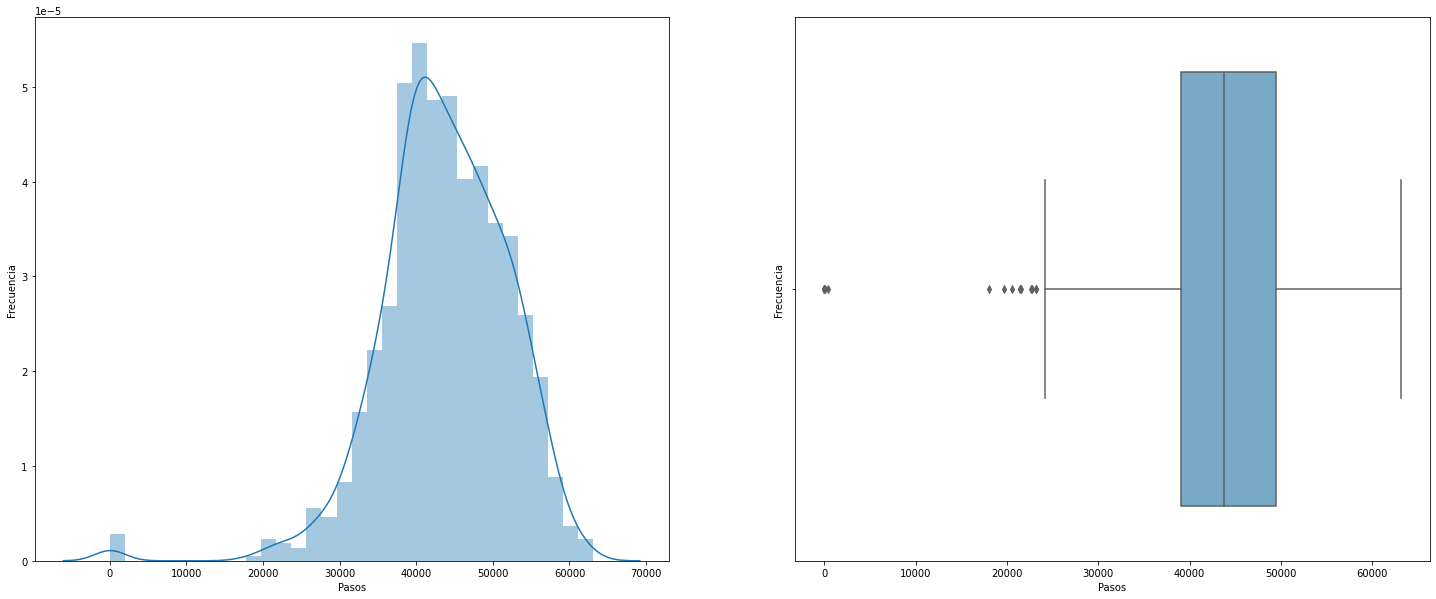

In [59]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.subplots_adjust(hspace=0.5, wspace=0.2)
sns.distplot(a=diario.cantidad_pasos)
plt.ylabel("Frecuencia")
plt.xlabel("Pasos")

plt.subplot(1,2,2)
sns.boxplot(data=diario,x="cantidad_pasos",palette="Blues")
plt.ylabel("Frecuencia")
plt.xlabel("Pasos")

identificando que los datos presentan un poco de outliers, quiero ajustarlos un poco utilizando 1.5x la desviación con el metodo IQR

In [60]:
q1, q3 = diario['cantidad_pasos'].quantile(0.25), diario['cantidad_pasos'].quantile(0.75)
IQR = q3 - q1

upper = q3 + 1.5 * IQR
lower = q1 - 1.5 * IQR 

diario2 = diario[(diario.cantidad_pasos > lower) & (diario.cantidad_pasos < upper)]

C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Pasos')

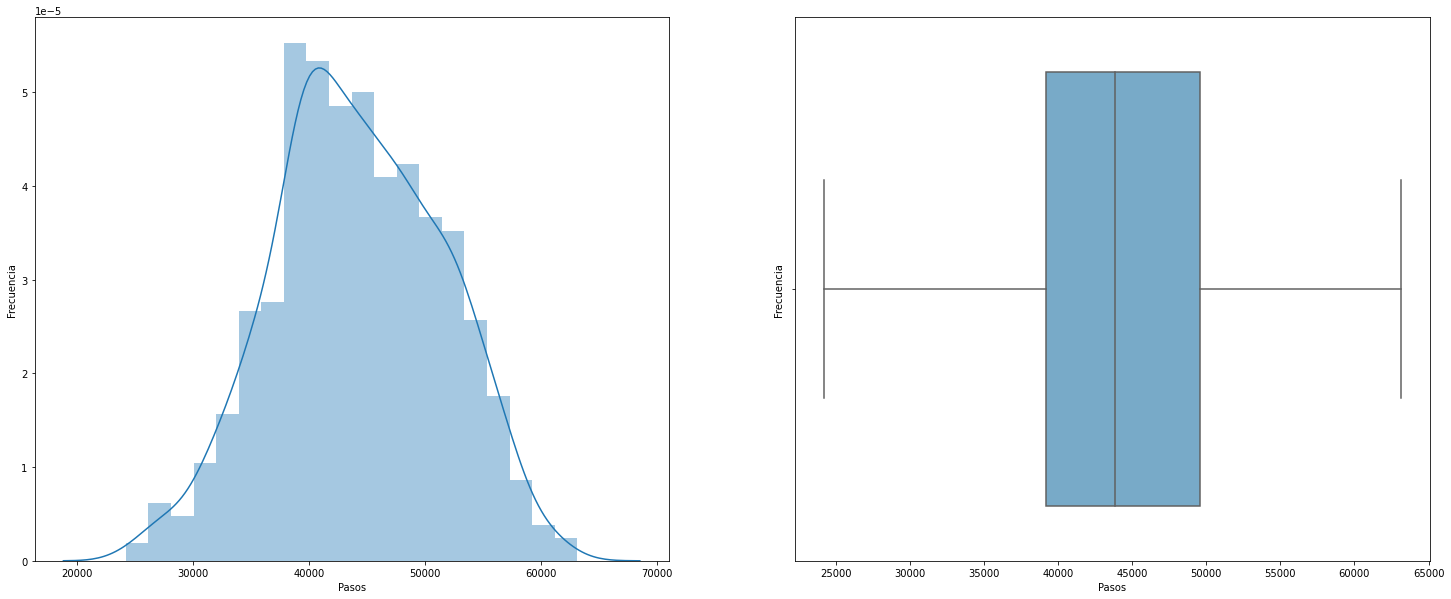

In [61]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.subplots_adjust(hspace=0.5, wspace=0.2)
sns.distplot(a=diario2.cantidad_pasos)
plt.ylabel("Frecuencia")
plt.xlabel("Pasos")

plt.subplot(1,2,2)
sns.boxplot(data=diario2,x="cantidad_pasos",palette="Blues")
plt.ylabel("Frecuencia")
plt.xlabel("Pasos")

Ahora si vemos como se nos ajusta mejor la distribución de los datos!!

siguiento entonces, vamos a calcular una ventana nueva para encontrar la tendencia de los datos:

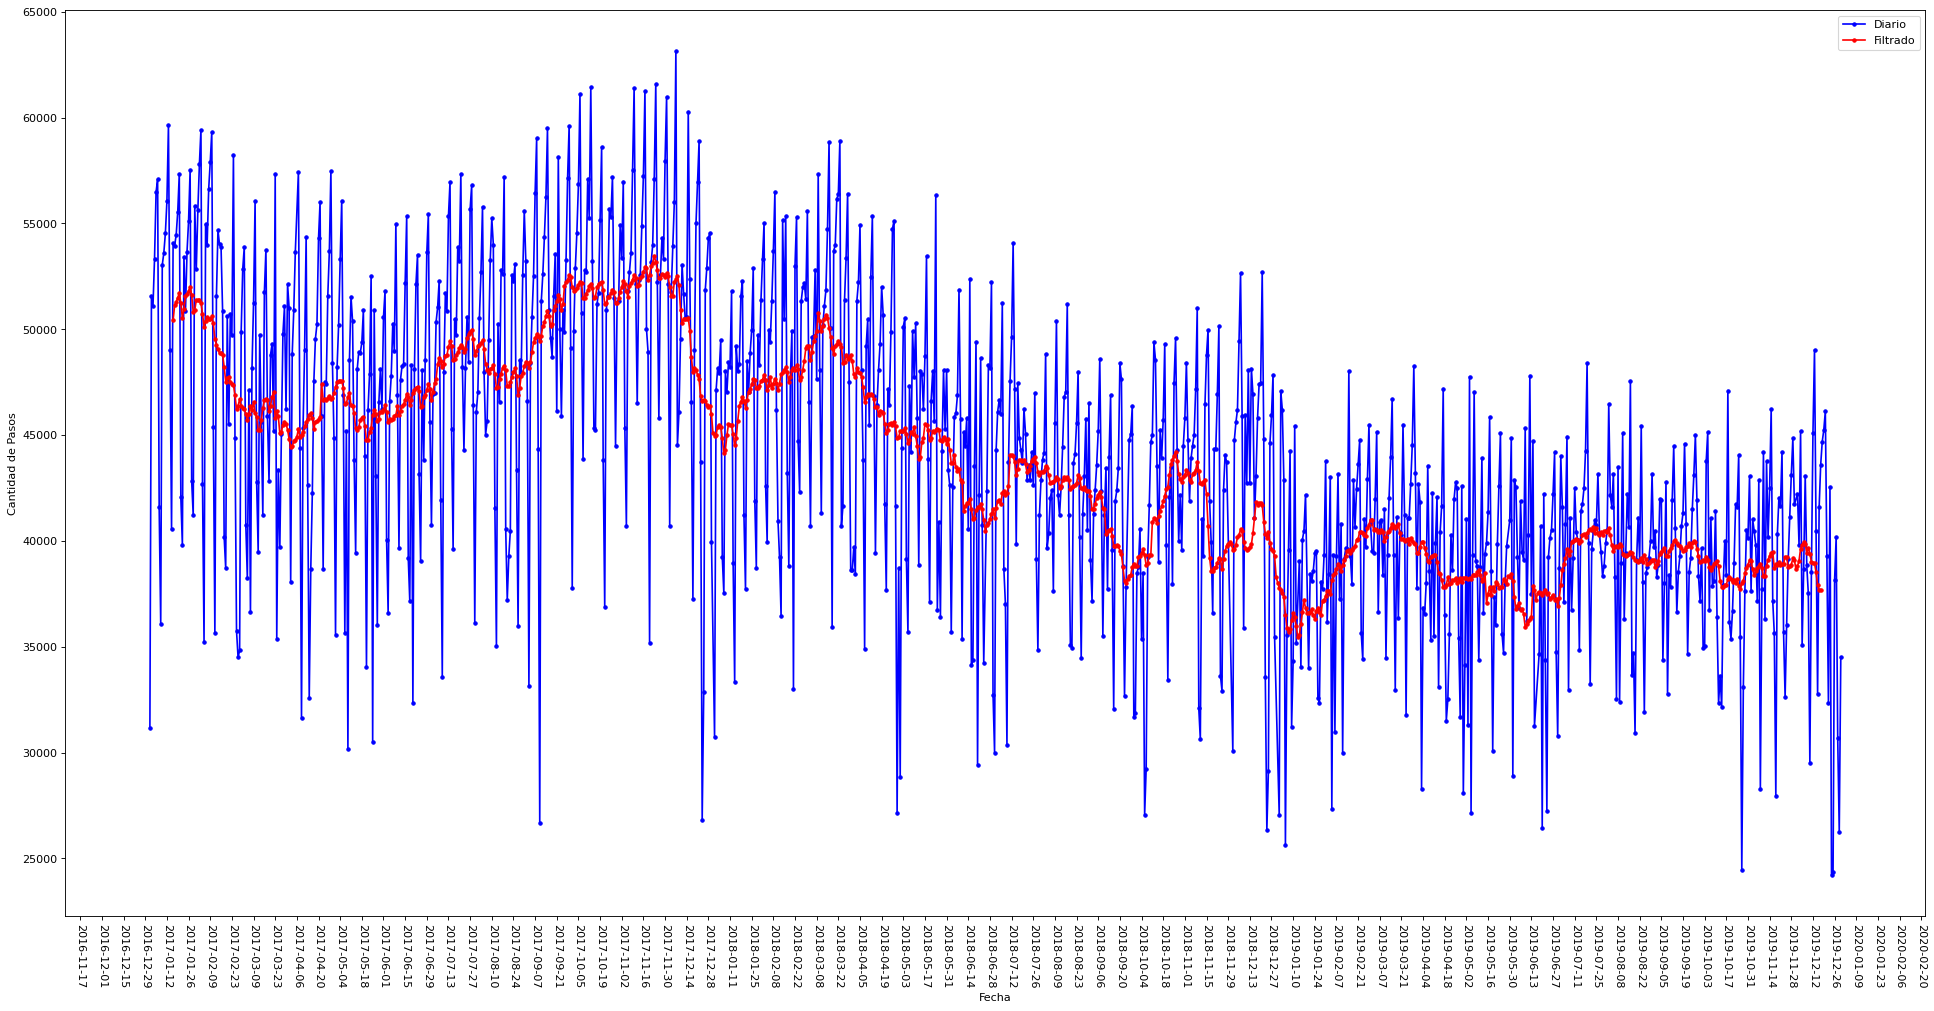

In [62]:
ventana = 30
promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()

fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(diario2.index, diario2.cantidad_pasos, 'b.-', label = 'Diario')
plt.plot(promedio_tendencia,  'r.-', label = 'Filtrado')
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

plt.show()

In [99]:
promedio_tendencia.shape

(1095,)

In [100]:
diario2.shape

(1079, 2)

In [63]:
diario2['fecha_numeros']=diario2.index.map(datetime.datetime.toordinal)
diario2

<ipython-input-63-60ee6b8c1e6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diario2['fecha_numeros']=diario2.index.map(datetime.datetime.toordinal)


,cantidad_pasos,fecha_numeros
fecha,,
2017-01-01,31183,736330
2017-01-02,51568,736331
2017-01-03,51093,736332
2017-01-04,53332,736333
2017-01-05,56486,736334
...,...,...
2019-12-26,38168,737419
2019-12-27,40182,737420
2019-12-28,30681,737421


In [86]:
# benchmark: Hallamos la tendencia lineal para confirmar la tendicia bajista que se evidencia con el rolling
linear = LinearRegression()
linear.fit(diario2.fecha_numeros.values.reshape(-1, 1), diario2.cantidad_pasos)

LinearRegression()

In [87]:
pred=linear.predict(diario2.fecha_numeros.values.reshape(-1, 1))

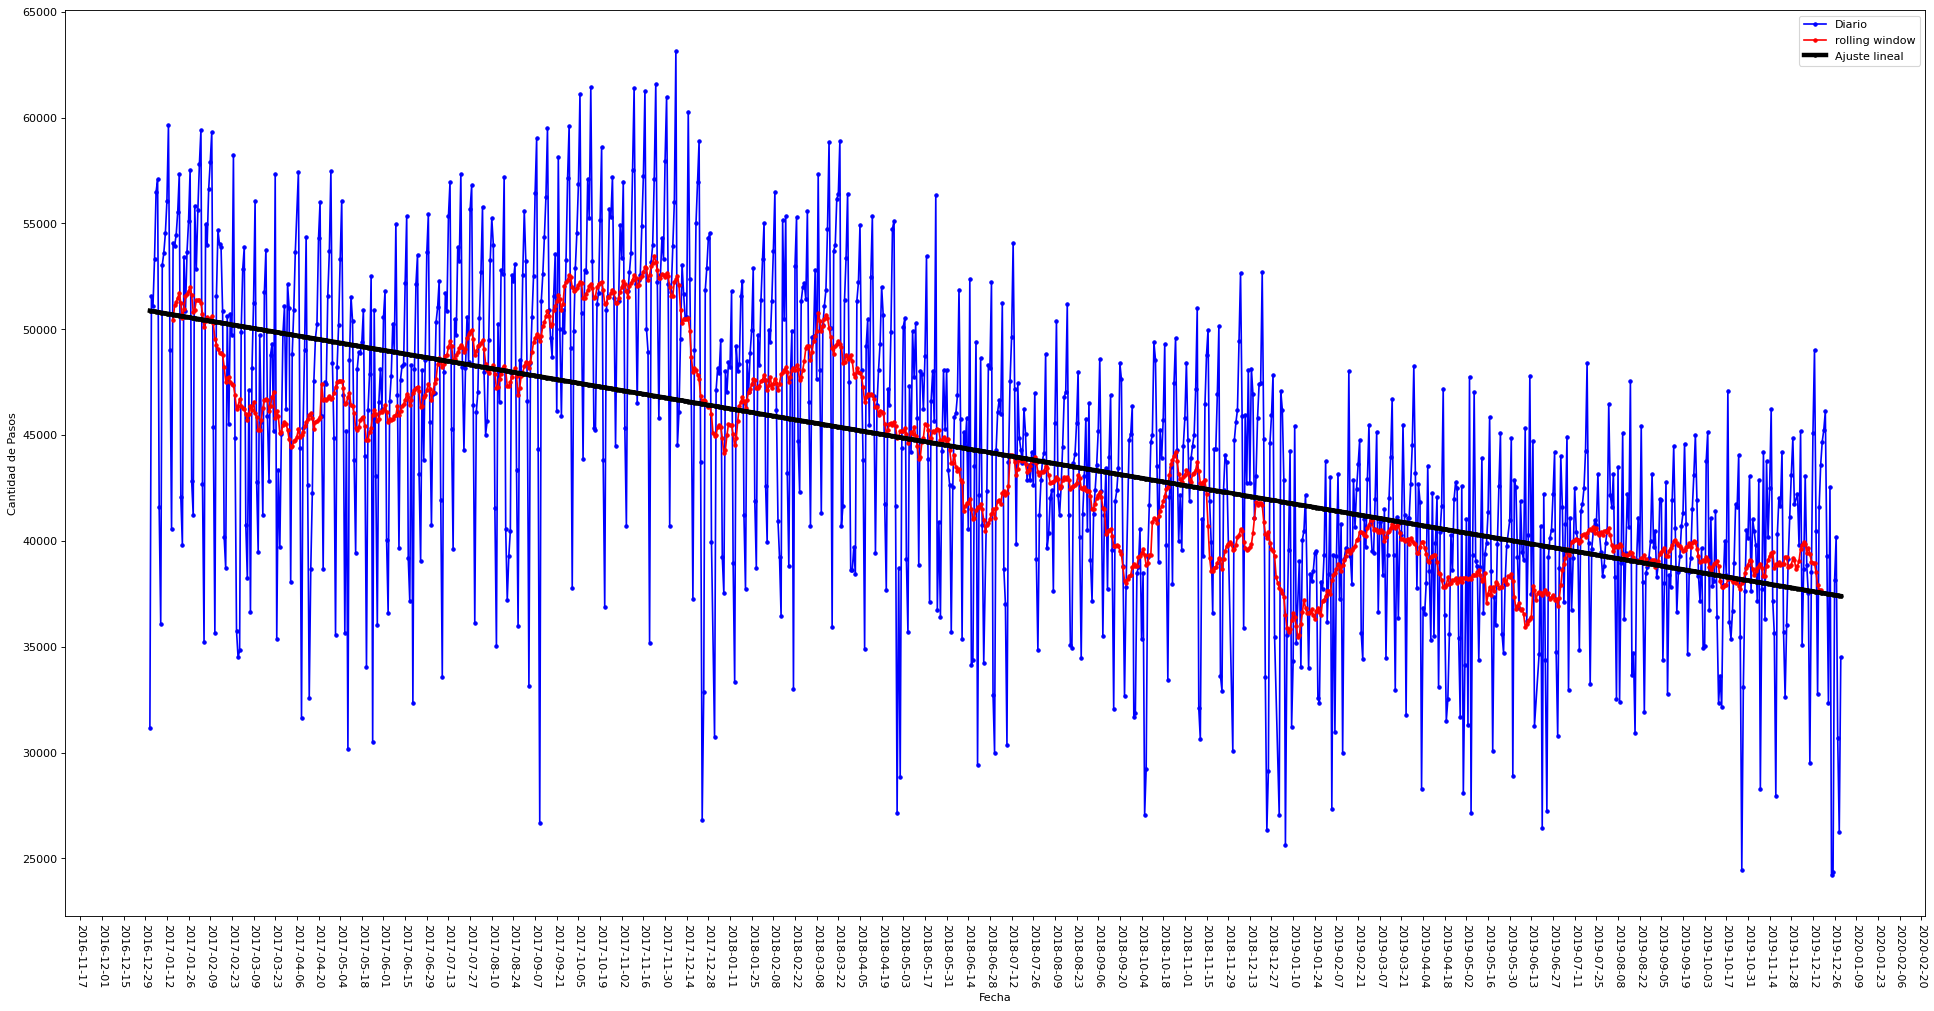

In [93]:
fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plt.plot(diario2.index, diario2.cantidad_pasos, 'b.-', label = 'Diario')
plt.plot(promedio_tendencia,  'r.-', label = 'rolling window')
plt.plot(diario2.index, pred, 'k.-', lw = 4,label = 'Ajuste lineal')
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.xticks(rotation=-90)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()

plt.show()

Ahora nos falta calcular la diferencia entre la serie original y la serie de tendencia.
vamos a calcularla y a ver los 3 componentes juntos:

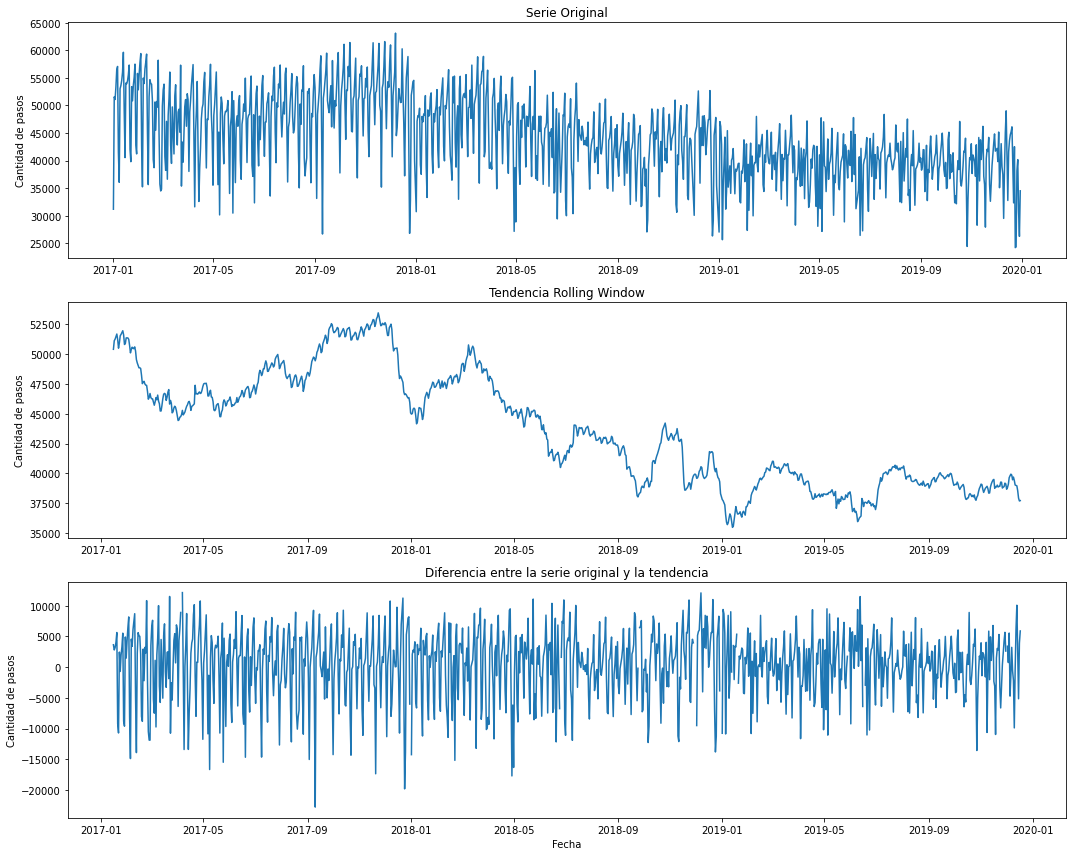

In [102]:
plt.figure(figsize = (15,12))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario2.index, diario2.cantidad_pasos)
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(promedio_tendencia)
plt.ylabel('Cantidad de pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(promedio_tendencia.index, diario2.cantidad_pasos - promedio_tendencia)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')

plt.tight_layout()
plt.show()

<ipython-input-145-8e69e3e9d006>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(diario2.cantidad_pasos, freq=freq_, model='additive')


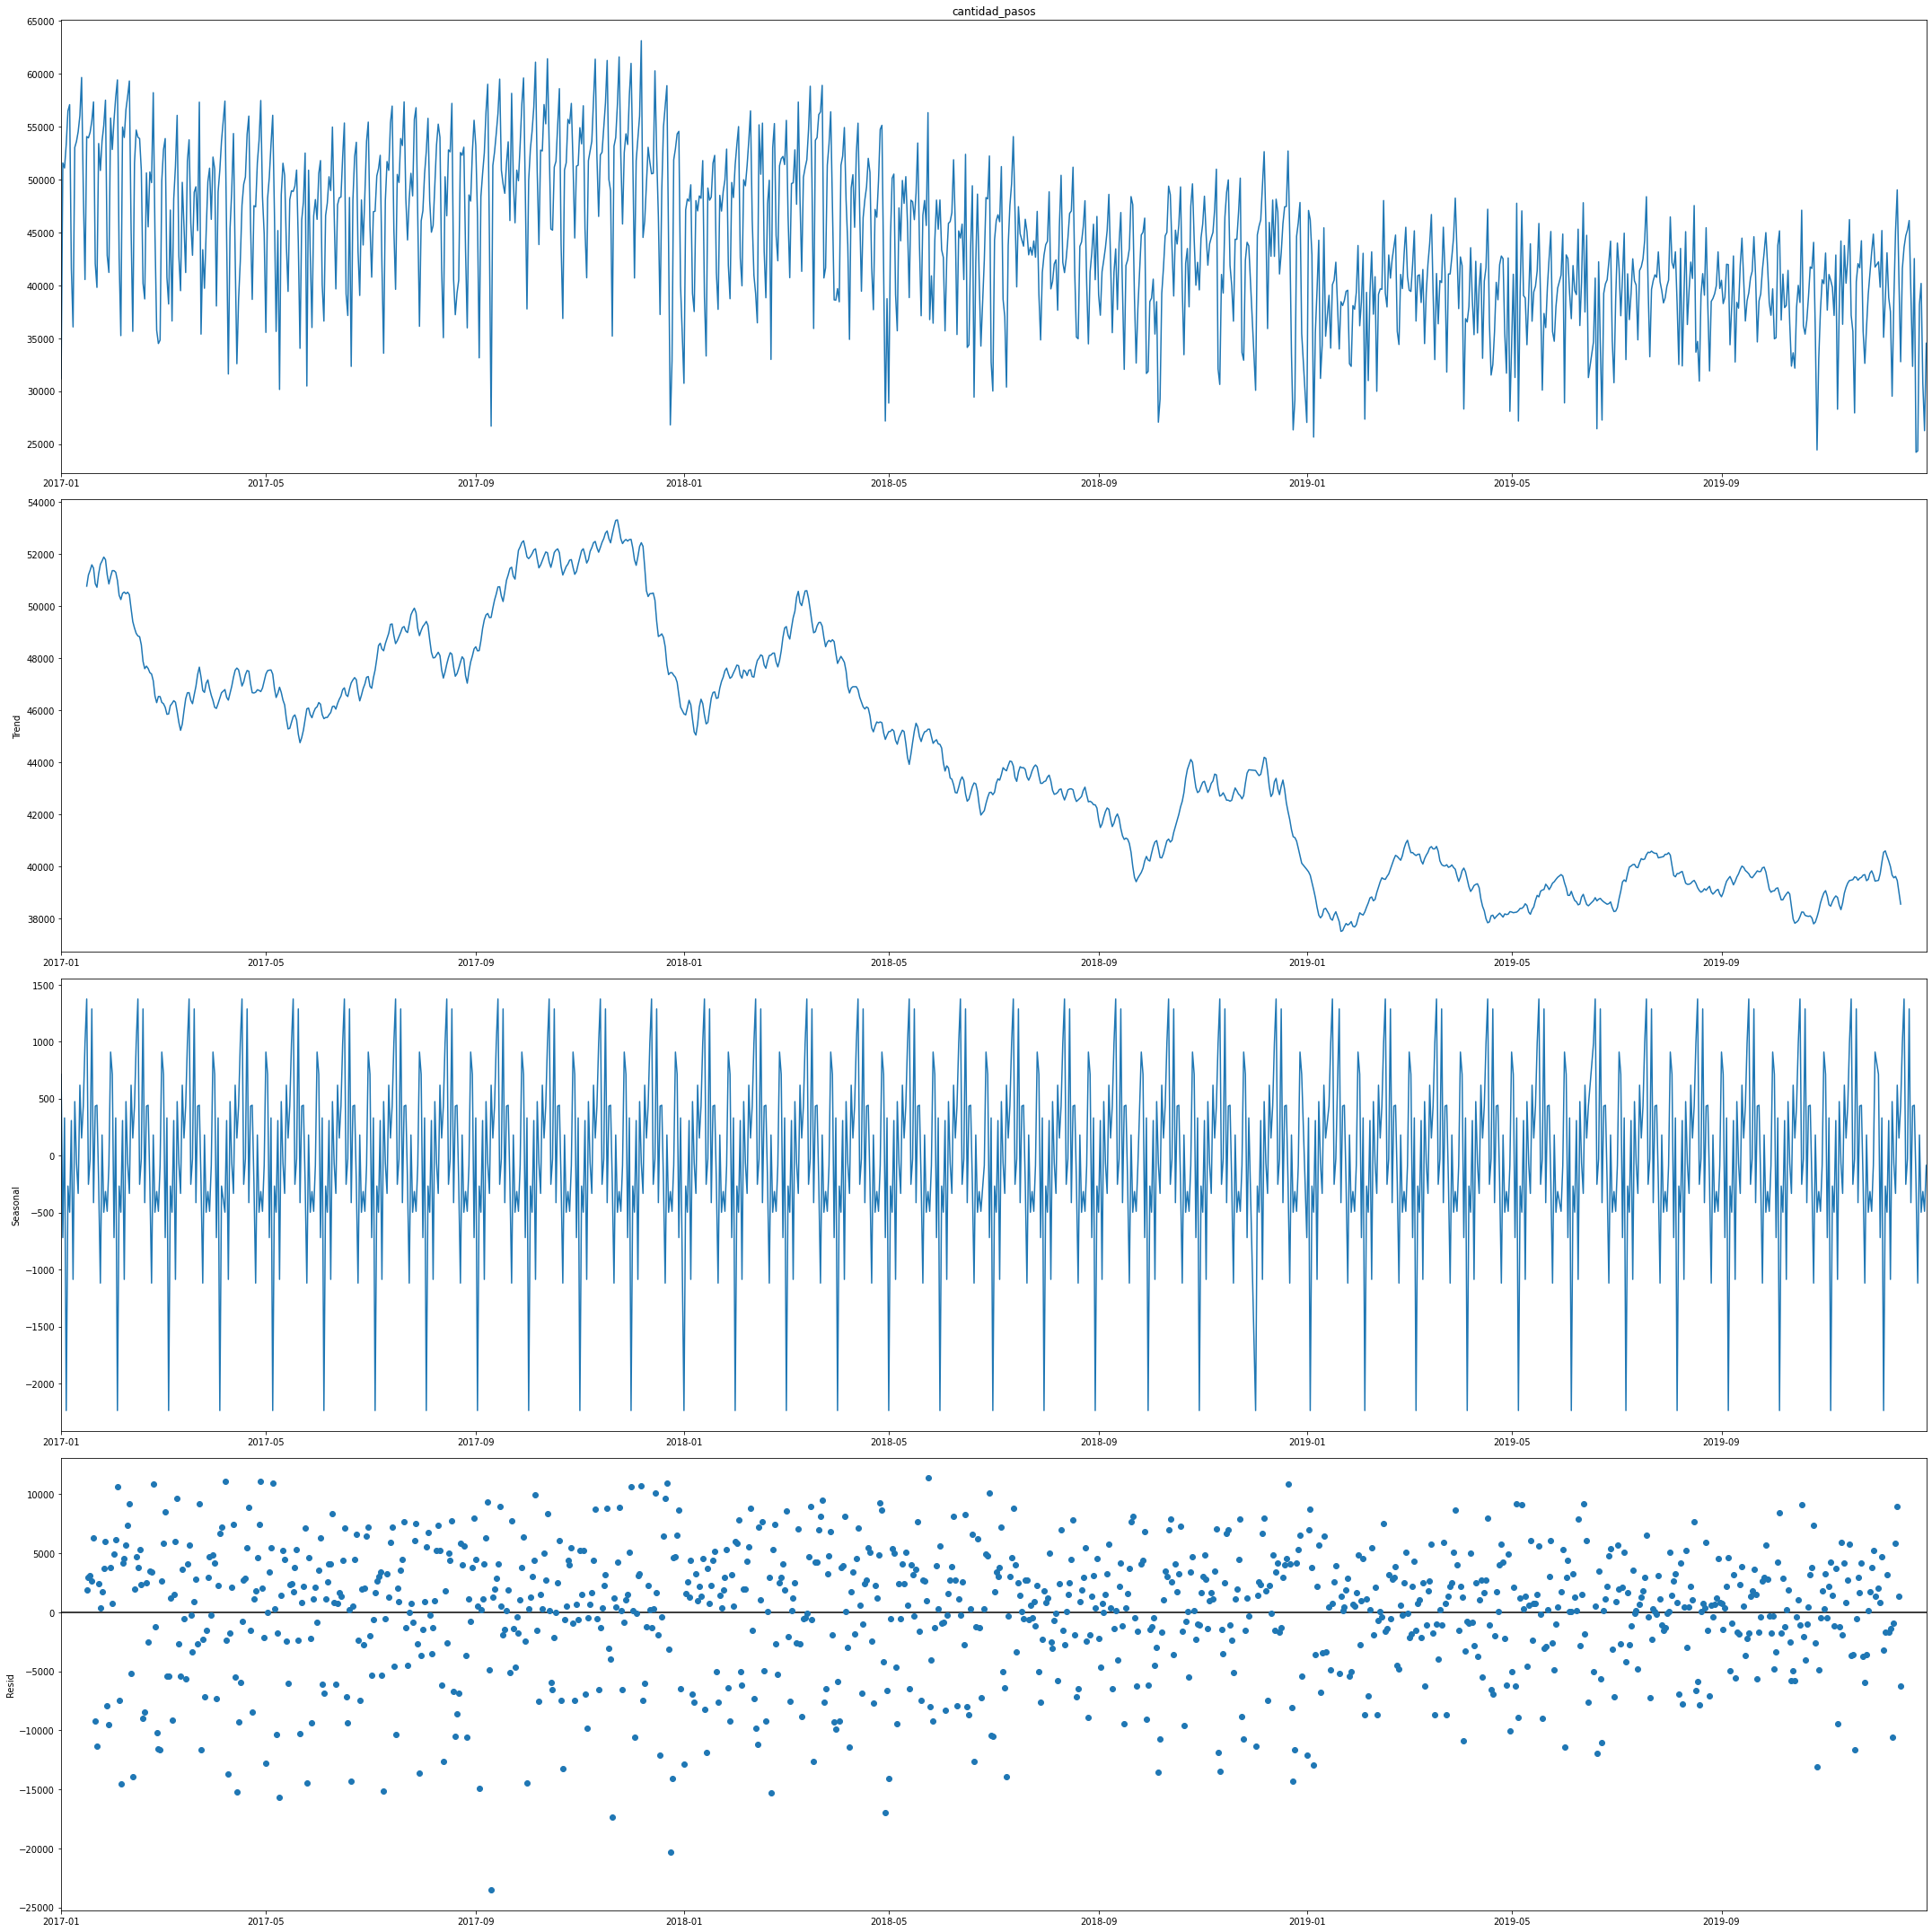

In [145]:
freq_=30
result = seasonal_decompose(diario2.cantidad_pasos, freq=freq_, model='additive')
plt.rcParams['figure.figsize'] = [30,30]
result.plot()
plt.show()

Se observa que claramente la serie tiene tendencia decreciente con una componente esacional entre -2000 y +1500 vehículos por día. Por último la parte residual entre +1000 y -1500 indica los extremos de la serie que es bastante fluctuante. los cuales creo que los dias de circulación tienen una parte muy importante para explicar este comportamiento

### Predicción

C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


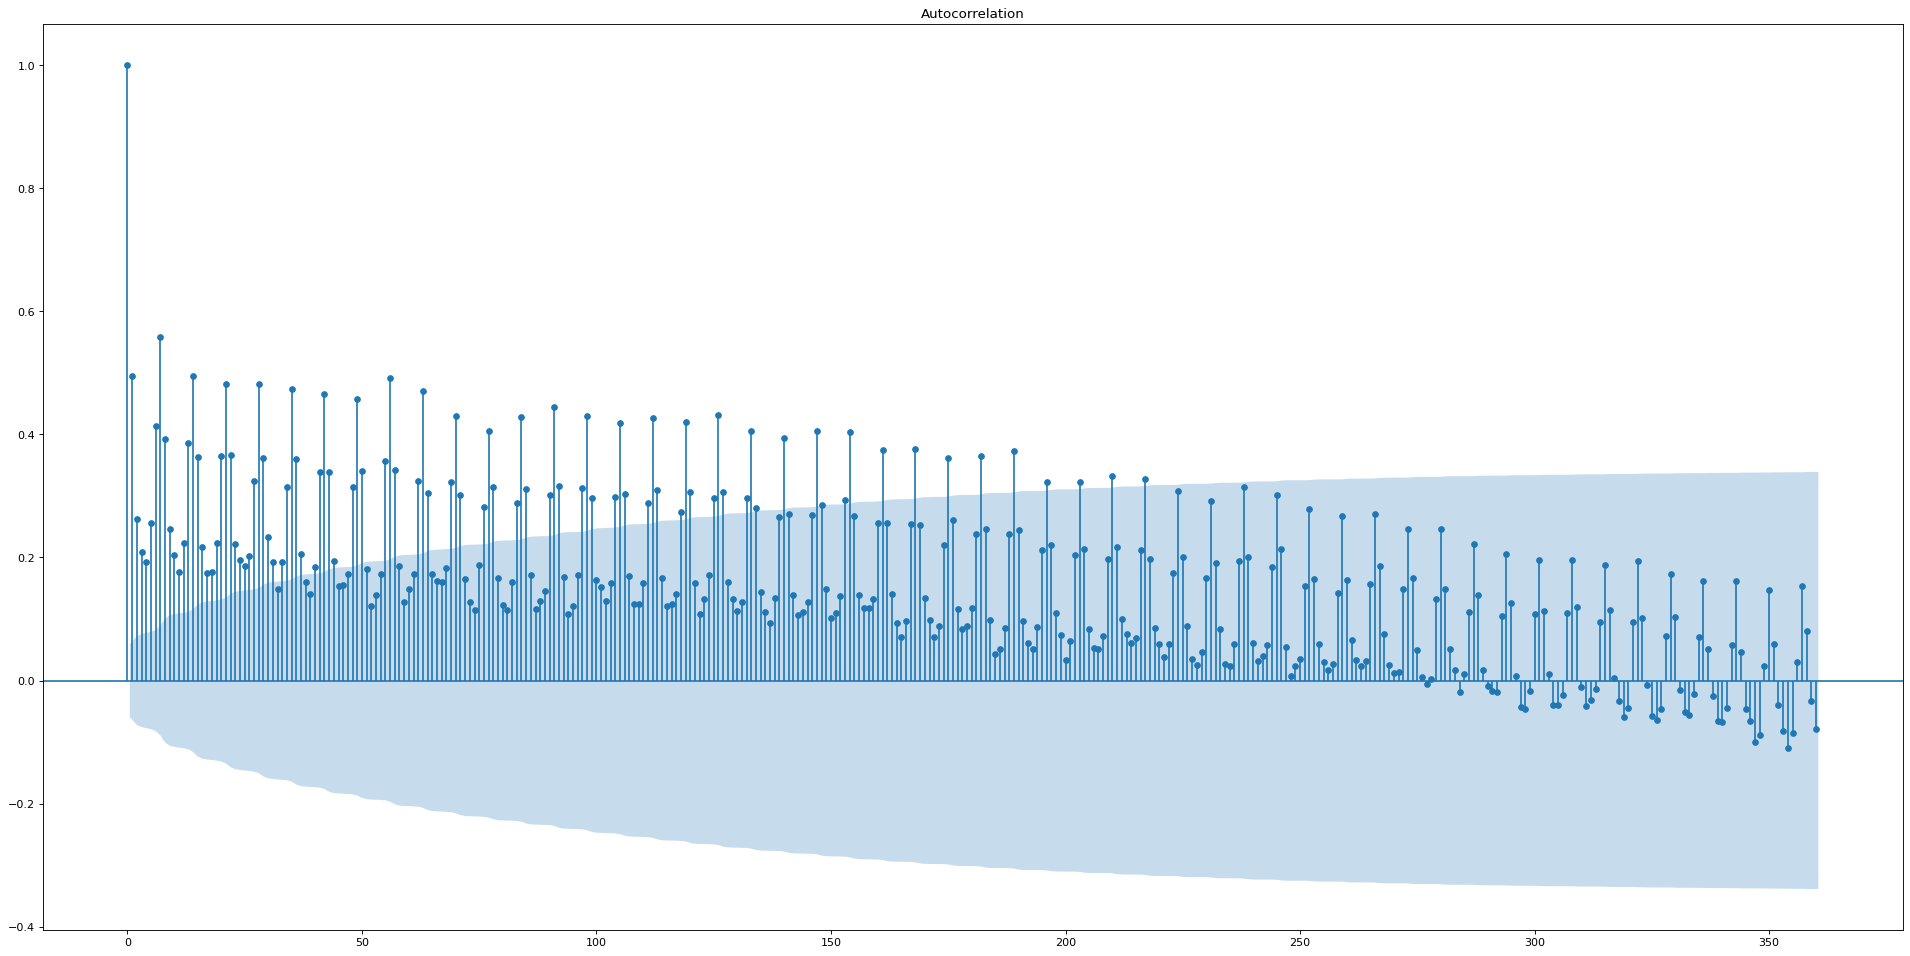

In [105]:
#Arrancamos con la autocorrelación de los datos
nlags=30*12
autocorr = acf(diario.cantidad_pasos, nlags = nlags)

fig, ax = plt.subplots(figsize=(30,15), dpi= 80)
plot_acf(diario.cantidad_pasos, lags =nlags,ax=ax)
plt.show()

In [106]:
# Ahora comienzo a trabajar en la búsqueda y realización de un predictor
diario = diario.rename(columns={'cantidad_pasos': 'y'})
#senial = diario.y.astype(int)
senial = diario.y
senial.shape

(1095,)

In [107]:
look_back = 30 # Cantidad de dias que voy a usar para prdecir el siguiente valor
steps = 92  # Cantidad de valores que quiero predecir. teniendo en cuenta dos meses de 31 días

N = senial.shape[0] 
X = np.zeros((N - look_back - 1,look_back))  
y = np.zeros(N - look_back - 1) 
print(X.shape,y.shape)

# se llenan las matrices con los valores
for i in range(X.shape[0]):
    X[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

X_train = X[:-steps,:]
y_train = y[:-steps]
print(X_train.shape, y_train.shape)

X_test = X[-steps:,:]
y_test = y[-steps:]
print(X_test.shape, y_test.shape)

(1064, 30) (1064,)
(972, 30) (972,)
(92, 30) (92,)


Ya teniendo el dataset separado en train y test, procedemos a realizar las predicciones evaluando los errores de predicción segun el RMSE y el R2 comparandolo contra el modelo benchmark:

In [120]:
RandomForest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = 4)
RandomForest.fit(X_train,y_train)

y_train_pred = RandomForest.predict(X_train)
y_test_pred = RandomForest.predict(X_test)

# Calculo el error RMSE en train y test.
rmse_forest_train = mean_squared_error(y_train, y_train_pred)
r2_f_train = r2_score(y_train, y_train_pred)
print('Error en Train para forest:',np.sqrt(rmse_forest_train))
print('R2 en Train para forest:',r2_f_train)

rmse_forest_test = mean_squared_error(y_test, y_test_pred)
r2_f_test = r2_score(y_test, y_test_pred)
print('Error en Test para forest:',np.sqrt(rmse_forest_test))
print('R2 en Test para forest:',r2_f_train)

#benchmark
rl = LinearRegression()
rl.fit(X_train, y_train)
rl_train = rl.predict(X_train)
rl_test = rl.predict(X_test)
print("\n")
rmse_rltrain = np.sqrt(mean_squared_error(y_train, rl_train))
r2_rltrain = r2_score(y_train, rl_train)
print('Error en Train para benchmark:',np.sqrt(rmse_rltrain))
print('R2 en Train para benchmark:',r2_rltrain)

rmse_rltest = np.sqrt(mean_squared_error(y_test, rl_test))
r2_rltest = r2_score(y_test, rl_test)
print('Error en Test para benchmark:',np.sqrt(rmse_rltest))
print('R2 en Test para benchmark:',r2_rltest)

Error en Train para forest: 2269.5021041488167
R2 en Train para forest: 0.9224053049649396
Error en Test para forest: 5065.159745723185
R2 en Test para forest: 0.9224053049649396


Error en Train para benchmark: 77.04203659968593
R2 en Train para benchmark: 0.46925993859374904
Error en Test para benchmark: 73.13944207442911
R2 en Test para benchmark: 0.05214577873174031


Con estos resultados vemos que le modelo benchmark, realmente no esta explicando el comportamiento de los datos, por lo que no es un modelo adecuado para realizar predicciones de datos. por el contrario, en los modelos de forest, vemos como R2 nos confirma ser un modelo interesante

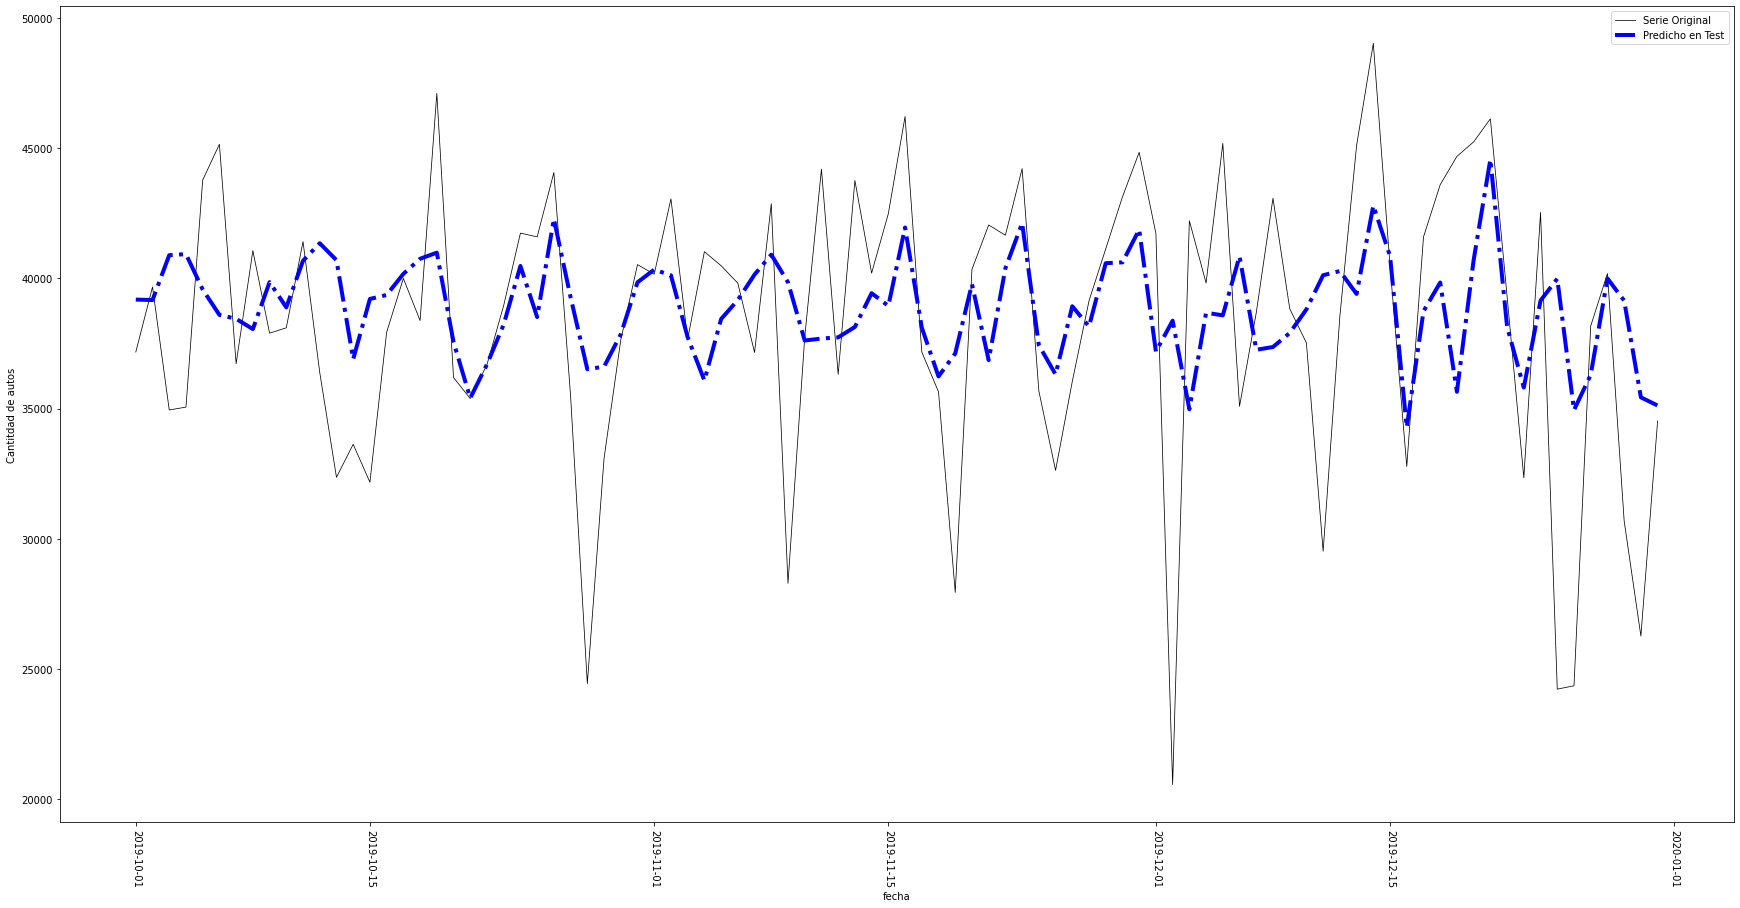

In [119]:
plt.figure(figsize=(30,15))
plt.plot(diario.index[-steps:], y_test,lw = 0.75, label = 'Serie Original',color = "black")
plt.plot(diario.index[-steps:], y_test_pred,'-.', lw = 4, label = 'Predicho en Test', color = "blue")
plt.legend()
plt.xticks(rotation=-90)
plt.xlabel('fecha')
plt.ylabel('Cantitdad de autos')
plt.show()

hasta ahora tenemos una relación cercana entre los datos reales del dataset y los predichos con el modelo de random forest. Vamos a realizar una iteración adicional en el que ajustemos un poco mas el tiempo para hacer la predicción

Continuemos con la optimización de los hiperparametros, para encontrar en el modelo de random forest un mejor resultado que el encontrado inicialmente y que nos de una mejor respuesta en la predicción de los datos

In [137]:
randomf = RandomForestRegressor()

parametros = {'n_estimators' : [10, 50, 90, 150],
             'max_depth' : np.arange(8,15),
             'bootstrap' : [True,False],
             'n_jobs':np.arange(0,10)}

random_search = RandomizedSearchCV(estimator = randomf, param_distributions = parametros, n_iter = 10, cv = 5, random_state = 42)

In [138]:
random_search.fit(X_train, y_train)

C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\ensemble\_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\joblib\parallel.py", line 966, in __call__
    n_jobs = self._initialize_backend()
  File "C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packag

C:\Users\JuanPabloEspinosaCas\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.45909587 -0.40379055  0.21895254  0.18526082 -0.41399019         nan
  0.23803787 -0.44873703  0.23133311 -0.44412454]
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': [10, 50, 90, 150],
                                        'n_jobs': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=42)

In [139]:
random_search.best_params_

{'n_jobs': 2, 'n_estimators': 150, 'max_depth': 14, 'bootstrap': True}

In [140]:
random_opt = RandomForestRegressor(n_estimators = 150, max_depth = 14, bootstrap = True,random_state=42,n_jobs = 2)
random_opt.fit(X_train, y_train)

RandomForestRegressor(max_depth=14, n_estimators=150, n_jobs=2, random_state=42)

In [141]:
random_train = random_opt.predict(X_train)
random_test = random_opt.predict(X_test)

rmse_randomtrain = np.sqrt(mean_squared_error(y_train, random_train))
rmse_randomtest = np.sqrt(mean_squared_error(y_test, random_test))
r2_randomtrain = r2_score(y_train, random_train)
r2_randomtest = r2_score(y_test, random_test)

print("Error RMSE en train",rmse_randomtrain)
print("Error RMSE en test",rmse_randomtest,"\n")
print("R2 en train",r2_randomtrain)
print("R2 en test",r2_randomtest)

Error RMSE en train 2372.776936448829
Error RMSE en test 5107.385406562794 

R2 en train 0.9151826546118231
R2 en test 0.1359632024609413


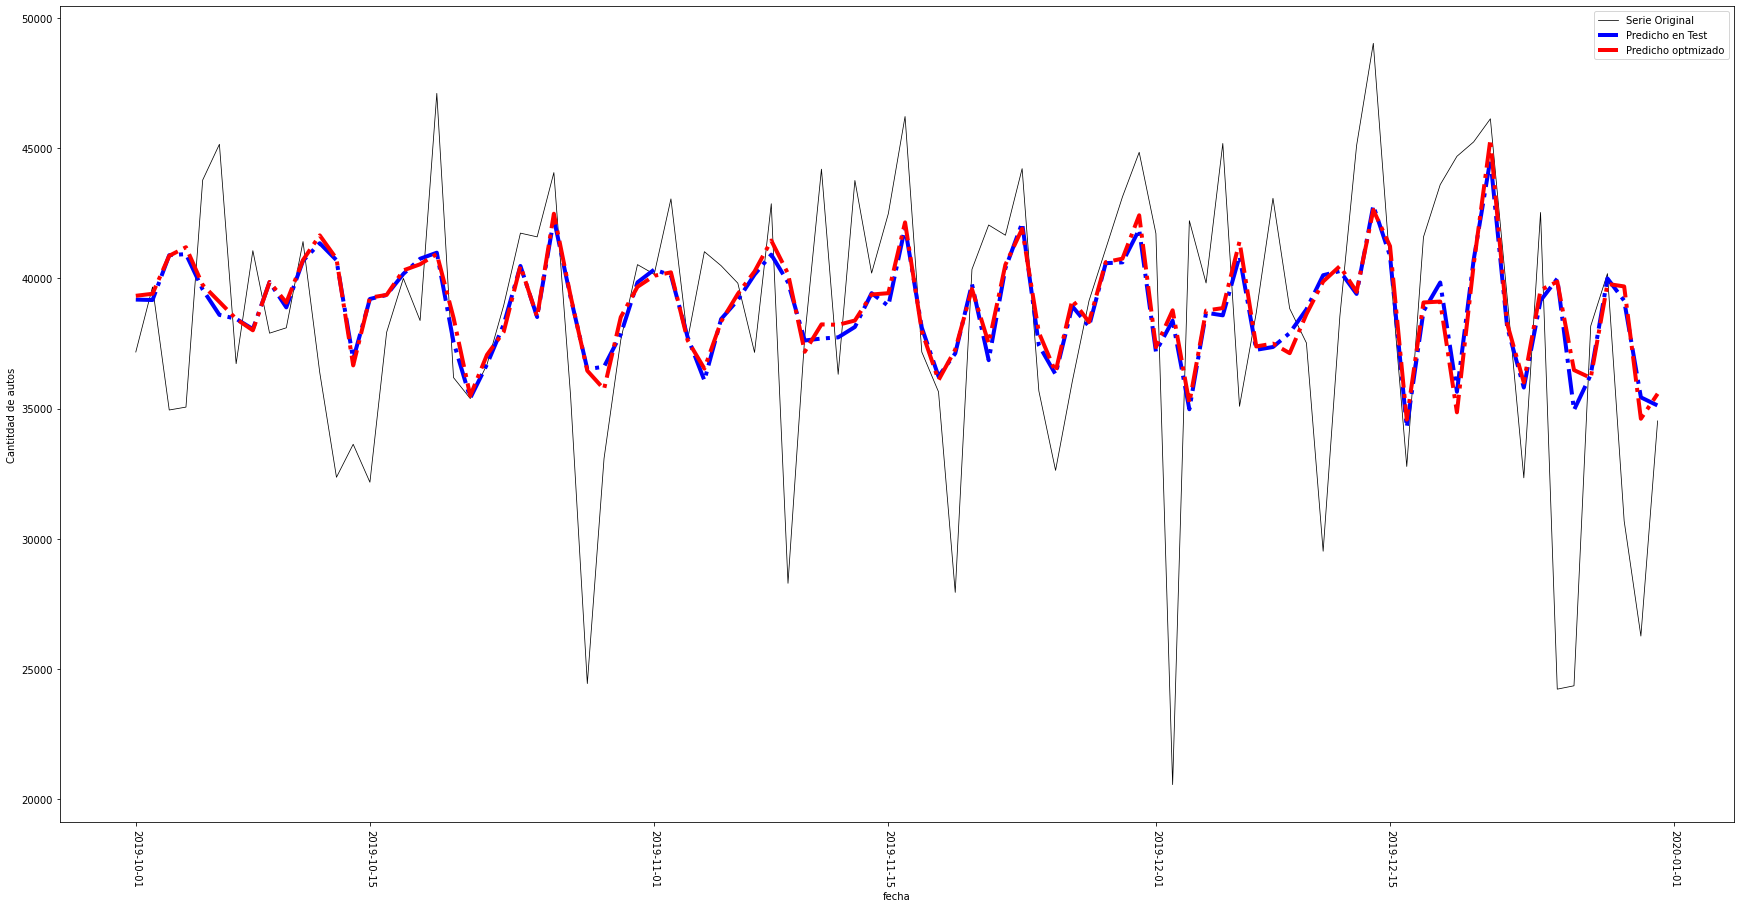

In [143]:
plt.figure(figsize=(30,15))
plt.plot(diario.index[-steps:], y_test,lw = 0.75, label = 'Serie Original',color = "black")
plt.plot(diario.index[-steps:], y_test_pred,'-.', lw = 4, label = 'Predicho en Test', color = "blue")
plt.plot(diario.index[-steps:], random_test,'-.', lw = 4, label = 'Predicho optmizado', color = "red")
plt.legend()
plt.xticks(rotation=-90)
plt.xlabel('fecha')
plt.ylabel('Cantitdad de autos')
plt.show()

### Conclusión

Con base a los resultados obtenidos en el modelo estudiado pudimos ver una evolución positiva en los resultados, en donde disminuye el overfitting que se puede observar en el modelo de Random Forest con parámetros elegidos al azar con una explicacion importante de sus variables en el modelo (superior al 90%).
Por otro lado,el modelo elegido como benchmark es bastante inferior a los resultados arrojados por el modelo estudiado y optimizado, lo cual era de esperarse al tratarse de u modelo con fluctuaciones importantes (como son los pasos en semana y la estacionalidad de los datos), que no son explicados de la mejor manera por un modelo de regresion lineal.

Si hubieramos estudiado el caso, no solamente con una autopista y considerando la importancia de los dias o incluso separando la tipologia de los vehiculos, posiblemente tendriamos resultados con unos errores mas bajos. Creo que este sería una opción interesante, al igual que la forma de pago para centrar opciones de estudio y sacar conclusiones.
con esto podriamos identificar si en todas las autopistas la tendencia en decreciente. como la tipologia de los automoviles me afecta en los resultados y si se implementan estrategias diferentes en horario como mejora/empeora los resultados. 

Durante el estudio del caso me surge la pregunta, como fue el comportamiento segun el tipo de pago.. si obedece a la tendencia mundial y a la actualidad que la forma de pago en efectivo debe tender a ser menor a medida que pasa el tiempo..

